# Wikimedia Research - Translation Imbalances: Testing hypothesis #2

# 1. Tests

#### Initial test with dumps

In [ ]:
# import libraries here
import gzip  # necessary for decompressing dump file into text format
import pandas as pd
import numpy as np

__NOTE__: The MediaWiki API can be language specific. We can use it to contruct the relevant datasets of the users we need. The following will yield different results:
- https://es.wikipedia.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount
- https://de.wikipedia.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount
- https://www.mediawiki.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount&format=json

In [19]:
import requests

url = "https://www.mediawiki.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount&format=json"

# Making a GET request
response = requests.get(url)
# See status code
print(response.status_code)
# See request text
print(response.text)

response.json()


200
{"batchcomplete":"","query":{"users":[{"userid":398607,"name":"Adamw","editcount":1507}]}}


{'batchcomplete': '',
 'query': {'users': [{'userid': 398607, 'name': 'Adamw', 'editcount': 1507}]}}

In [20]:
import requests

url = "https://en.wikipedia.org/w/rest.php/v1/search/page?q=earth&limit=1"

# Making a GET request
response = requests.get(url)
# See URL
response.url
# See status code
response.status_code
# See request header
response.text


'{"pages":[{"id":9228,"key":"Earth","title":"Earth","excerpt":"<span class=\\"searchmatch\\">Earth</span> is the third planet from the Sun and the only place known in the universe where life has originated and found habitability. <span class=\\"searchmatch\\">Earth</span> is the only planet","matched_title":null,"description":"Third planet from the Sun","thumbnail":{"mimetype":"image/jpeg","width":60,"height":60,"duration":null,"url":"//upload.wikimedia.org/wikipedia/commons/thumb/c/cb/The_Blue_Marble_%28remastered%29.jpg/60px-The_Blue_Marble_%28remastered%29.jpg"}}]}'

# 2. Implementation

## Data collection

In [131]:
# import general libraries
import csv
import ast
import re
import requests
import pandas as pd

In [132]:
# we are adding this list because the CSV files includes items that are not in it
allowed_languages = ['aa', 'ab', 'ace', 'ady', 'af', 'ak', 'als', 'alt', 'am', 'ami', 'an', 'ang', 'ar', 'arc', 'ary',
                     'arz', 'as', 'ast', 'atj', 'av', 'avk', 'awa', 'ay', 'az', 'azb', 'ba', 'ban', 'bar', 'bat-smg',
                     'bcl', 'be', 'be-tarask', 'bg', 'bh', 'bi', 'bjn', 'blk', 'bm', 'bn', 'bo', 'bpy', 'br', 'bs',
                     'bug', 'bxr', 'ca', 'cbk-zam', 'cdo', 'ce', 'ceb', 'ch', 'cho', 'chr', 'chy', 'ckb', 'co', 'cr',
                     'crh', 'cs', 'csb', 'cu', 'cv', 'cy', 'da', 'dag', 'de', 'din', 'diq', 'dsb', 'dty', 'dv', 'dz',
                     'ee', 'el', 'eml', 'en', 'eo', 'es', 'et', 'eu', 'ext', 'fa', 'ff', 'fi', 'fiu-vro', 'fj', 'fo', 
                     'gur', 'fr', 'frp', 'frr', 'fur', 'fy', 'ga', 'gag', 'gan', 'gcr', 'gd', 'gl', 'glk', 'gn', 'gom',
                     'gor', 'got', 'gu', 'guw', 'gv', 'ha', 'hak', 'haw', 'he', 'hi', 'hif', 'ho', 'hr', 'hsb', 'ht', 
                     'hu', 'hy', 'hyw', 'hz', 'ia', 'id', 'ie', 'ig', 'ii', 'ik', 'ilo', 'inh', 'io', 'is', 'it', 'iu',
                     'ja', 'jam', 'jbo', 'jv', 'ka', 'kaa', 'kab', 'kbd', 'kbp', 'kcg', 'kg', 'ki', 'kj', 'kk', 'kl', 
                     'km', 'kn', 'ko', 'koi', 'kr', 'krc', 'ks', 'ksh', 'ku', 'kv', 'kw', 'ky', 'la', 'lad', 'lb', 'lbe', 
                     'lez', 'lfn', 'lg', 'li', 'lij', 'lld', 'lmo', 'ln', 'lo', 'lrc', 'lt', 'ltg', 'lv', 'mad', 'mai', 
                     'map-bms', 'mdf', 'mg', 'mh', 'mhr', 'mi', 'min', 'mk', 'ml', 'mn', 'mni', 'mnw', 'mr', 'mrj', 'ms',
                     'mt', 'mus', 'mwl', 'my', 'myv', 'mzn', 'na', 'nah', 'nap', 'nds', 'nds-nl', 'ne', 'new', 'ng', 'nia',
                     'nl', 'nn', 'no', 'nov', 'nqo', 'nrm', 'nso', 'nv', 'ny', 'oc', 'olo', 'om', 'or', 'os', 'pa', 'pag',
                     'pam', 'pap', 'pcd', 'pcm', 'pdc', 'pfl', 'pi', 'pih', 'pl', 'pms', 'pnb', 'pnt', 'ps', 'pt', 'pwn',
                     'qu', 'rm', 'rmy', 'rn', 'ro', 'roa-rup', 'roa-tara', 'ru', 'rue', 'rw', 'sa', 'sah', 'sat', 'sc',
                     'scn', 'sco', 'sd', 'se', 'sg', 'sh', 'shi', 'shn', 'si', 'simple', 'sk', 'skr', 'sl', 'smn', 'sm', 
                     'sn', 'so', 'sq', 'sr', 'srn', 'ss', 'st', 'stq', 'su', 'sv', 'sw', 'szl', 'szy', 'ta', 'tay', 'tcy',
                     'te', 'tet', 'tg', 'th', 'ti', 'tk', 'tl', 'tn', 'to', 'tpi', 'tr', 'trv', 'ts', 'tt', 'tum', 'tw', 'ty',
                     'tyv', 'udm', 'ug', 'uk', 'ur', 'uz', 've', 'vec', 'vep', 'vi', 'vls', 'vo', 'wa', 'war', 'guc', 'wo', 'wuu',
                     'xal', 'xh', 'xmf', 'yi', 'yo', 'za', 'zea', 'zh', 'zh-classical', 'zh-min-nan', 'zh-yue', 'zu']

In [133]:
## Collect users and languages
from csv import DictReader

# open file in read mode and convert to list of dictionaries
with open('data/user_languages_user_template.csv', encoding="utf8") as f:
    users = csv.DictReader(f)
    user_dictionary = {}
    
    # make headers lowercase
    users.fieldnames = [h.lower() for h in users.fieldnames]
    
    # iterate over results to initialize copy and set new columns
    for i, row in enumerate(users):

        # initialize fields
        row['edit_counts'] = []
        row['level_lang'] = []
        username = row['username'].split(':')[1]
        row['username'] = username
        
        # update mapper
        user_dictionary[username] =row
    
    
# out
display(users.fieldnames)
display(user_dictionary)    

['username', 'language']

{'Olivier LPB': {'username': 'Olivier LPB',
  'language': "['fr', 'en-2']",
  'edit_counts': [],
  'level_lang': []},
 'Gamesmasterg9': {'username': 'Gamesmasterg9',
  'language': "['en', 'hi-4', 'bn-3', 'mr-1']",
  'edit_counts': [],
  'level_lang': []},
 'Dvermeirre': {'username': 'Dvermeirre',
  'language': "['fr', 'en-5', 'de-1']",
  'edit_counts': [],
  'level_lang': []},
 'Jklamo': {'username': 'Jklamo',
  'language': "['en-3', 'cs', 'sk', 'fr-1']",
  'edit_counts': [],
  'level_lang': []},
 'Calliopejen1': {'username': 'Calliopejen1',
  'language': "['en', 'es-3', 'fr-1']",
  'edit_counts': [],
  'level_lang': []},
 'Jpbrenna': {'username': 'Jpbrenna',
  'language': "['en', 'el-2', 'la-2', 'es-2', 'ar-1']",
  'edit_counts': [],
  'level_lang': []},
 'WarKosign': {'username': 'WarKosign',
  'language': "['en-3', 'he-4', 'ru']",
  'edit_counts': [],
  'level_lang': []},
 'Appaches': {'username': 'Appaches',
  'language': "['fr', 'en-3']",
  'edit_counts': [],
  'level_lang': []},


## Data processing

Some possibilities is to have a dataframe that has 
[username],[language],[level],[edit count] 

In [134]:
## Clean initial data and update rows and prepare data for requests
from collections import defaultdict

# dictionary neede to make request by language and associated user list
language_match_dict = defaultdict(list)
    
for key, row in user_dictionary.items():
    username = row['username']
    languages = ast.literal_eval(row['language'])
    level_lang = []
    edit_keys = set()
    
    for lang in languages:    
        
        # TODO: AW: Push this into a separate function that can be tested.
        # split by digits with a preceding character ('-') and include it
        lang_extract = list(filter(None, re.split('-(\d)|-[A-Z]+', lang)))
        # get the language
        lang = lang_extract[0]
        # get language level if present, else, assume native level
        level = lang_extract[1] if len(lang_extract) > 1 else 5 
        
        if (lang in allowed_languages) and (lang not in edit_keys):
            # append
            level_lang.append((lang, level))
            # initialize key
            edit_keys.add(lang)

            # add to the user to the corresponding language group
            language_match_dict[lang].append(username)
    
    # update row columns after cleaning
    row['level_lang'] = level_lang
    # we are creating a dictionary to easily map and update by user and language after
    # getting the raw counts. We initialize to 0 to only update data that is not 'missing'
    row['edit_counts'] = dict.fromkeys(edit_keys, 0)
    # 'unset' language 
    del row['language']

# out
display(user_dictionary)

{'Olivier LPB': {'username': 'Olivier LPB',
  'edit_counts': {'fr': 0, 'en': 0},
  'level_lang': [('fr', 5), ('en', '2')]},
 'Gamesmasterg9': {'username': 'Gamesmasterg9',
  'edit_counts': {'en': 0, 'bn': 0, 'mr': 0, 'hi': 0},
  'level_lang': [('en', 5), ('hi', '4'), ('bn', '3'), ('mr', '1')]},
 'Dvermeirre': {'username': 'Dvermeirre',
  'edit_counts': {'fr': 0, 'en': 0, 'de': 0},
  'level_lang': [('fr', 5), ('en', '5'), ('de', '1')]},
 'Jklamo': {'username': 'Jklamo',
  'edit_counts': {'en': 0, 'cs': 0, 'fr': 0, 'sk': 0},
  'level_lang': [('en', '3'), ('cs', 5), ('sk', 5), ('fr', '1')]},
 'Calliopejen1': {'username': 'Calliopejen1',
  'edit_counts': {'en': 0, 'fr': 0, 'es': 0},
  'level_lang': [('en', 5), ('es', '3'), ('fr', '1')]},
 'Jpbrenna': {'username': 'Jpbrenna',
  'edit_counts': {'en': 0, 'ar': 0, 'es': 0, 'el': 0, 'la': 0},
  'level_lang': [('en', 5),
   ('el', '2'),
   ('la', '2'),
   ('es', '2'),
   ('ar', '1')]},
 'WarKosign': {'username': 'WarKosign',
  'edit_counts': {'e

In [138]:
## Per each language, make request to get the data and merge it with larger dictionary
# Reference: https://www.mediawiki.org/w/api.php?action=help&modules=query%2Busers
import traceback
from time import sleep

from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# general
user_edit_counts = defaultdict(list)
langs = list(language_match_dict.keys())

# set requests parameters to retry on 'Max retries exceeded with url' and have enough wait time between exceptions
session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('https://', adapter)

# used to track call number
api_call_number = 0

# initialize
slice_start = 0
slice_end = 50
#lang = langs.pop()
#next_lang = lang
#users_len = len(language_match_dict[lang])

while (len(langs) > 0) or (slice_end < users_len):
    try:
        # check to update slice values
        if slice_end >= users_len:
            print("checking...")
            lang = langs.pop() if langs else lang

            slice_start = 0
            slice_end = 50
            users_len = len(language_match_dict[lang])
        else:
            slice_start = slice_start + 50
            slice_end =  slice_end + 50 
            
        print('\n\n\n')
        print(f"LANG {lang}\nUSERS' LIST SIZE {users_len}")
        # work with uses batches that make request per 50 users within a user language group
        users_l = language_match_dict[lang][slice_start:slice_end]
        users =  "|".join(users_l)
        url = f'https://{lang}.wikipedia.org/w/api.php?action=query&list=users&ususers={users}&usprop=editcount&format=json'
        lang_call = lang    

        # GET request
        response = session.get(url)
        if response.status_code != 200:
            raise Exception(f"The call failed: {response.status_code}")

        else:
            # See request JSON
            res = response.json()['query']['users']
            print(res)

            # save results to dictionary to process later

            # AW: Although I like the encapsulation of each user's fetched
            # information under data/users/, it's more efficient to swap
            # containment levels and instead save a csv for all users' edit
            # counts on a language wiki, at the end of this function.  This
            # is a much smaller number of files, and matches the structure of
            # iteration in program logic which becomes helpful if eg. the
            # application crashes and must be restarted.
            print(f"lang_call\n\n {lang_call}")
            user_edit_counts[lang_call].extend(res)
           

            api_call_number += 1
            print(f'\n\nLIMIT: {len(users_l)} \n\nCALL NUMBER: {api_call_number}')
            
    
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    
    except Exception as e:
        print(e)
        traceback.print_exc()
      


checking...




LANG sw
USERS' LIST SIZE 1
[{'name': 'PoetishBookwormus', 'missing': ''}]
lang_call

 sw


LIMIT: 1 

CALL NUMBER: 1
checking...




LANG be
USERS' LIST SIZE 2
[{'userid': 51607, 'name': 'Artem.G', 'editcount': 2}, {'userid': 33259, 'name': 'Janka1410', 'editcount': 114}]
lang_call

 be


LIMIT: 2 

CALL NUMBER: 2
checking...




LANG gan
USERS' LIST SIZE 1
[{'userid': 24163, 'name': 'Richard923888', 'editcount': 3}]
lang_call

 gan


LIMIT: 1 

CALL NUMBER: 3
checking...




LANG tt
USERS' LIST SIZE 1
[{'userid': 2182, 'name': 'Firespeaker', 'editcount': 5}]
lang_call

 tt


LIMIT: 1 

CALL NUMBER: 4
checking...




LANG uz
USERS' LIST SIZE 1
[{'userid': 3612, 'name': 'Firespeaker', 'editcount': 0}]
lang_call

 uz


LIMIT: 1 

CALL NUMBER: 5
checking...




LANG kk
USERS' LIST SIZE 1
[{'userid': 29, 'name': 'Firespeaker', 'editcount': 24}]
lang_call

 kk


LIMIT: 1 

CALL NUMBER: 6
checking...




LANG ky
USERS' LIST SIZE 1
[{'userid': 319, 'name': 'Firespeaker', 'edit

[{'userid': 5560, 'name': 'Franz710', 'editcount': 163}]
lang_call

 pam


LIMIT: 1 

CALL NUMBER: 44
checking...




LANG mt
USERS' LIST SIZE 3
[{'userid': 7515, 'name': 'MatthewS.', 'editcount': 8}, {'userid': 15697, 'name': 'GhanimSharifi', 'editcount': 16}, {'userid': 16659, 'name': 'Pichemist', 'editcount': 5}]
lang_call

 mt


LIMIT: 3 

CALL NUMBER: 45
checking...




LANG bg
USERS' LIST SIZE 2
[{'userid': 134864, 'name': 'Kaliforniyka', 'editcount': 49}, {'userid': 303990, 'name': 'ElementSix', 'editcount': 0}]
lang_call

 bg


LIMIT: 2 

CALL NUMBER: 46
checking...




LANG my
USERS' LIST SIZE 2
[{'userid': 25564, 'name': 'Thureinminnoo', 'editcount': 6}, {'userid': 91244, 'name': 'Whopeehere', 'editcount': 179}]
lang_call

 my


LIMIT: 2 

CALL NUMBER: 47
checking...




LANG mn
USERS' LIST SIZE 2
[{'userid': 28385, 'name': 'Gdominik100', 'editcount': 3}, {'userid': 5444, 'name': 'Firespeaker', 'editcount': 0}]
lang_call

 mn


LIMIT: 2 

CALL NUMBER: 48
checking...




LANG 

[{'userid': 210384, 'name': '丘明利', 'editcount': 2}, {'userid': 240425, 'name': 'Phokhamvone', 'editcount': 0}, {'userid': 263740, 'name': 'Tris T7', 'editcount': 11721}, {'userid': 353892, 'name': 'PointlessUsername', 'editcount': 207}, {'userid': 420542, 'name': 'Haidit', 'editcount': 14}, {'userid': 436139, 'name': 'Bujsaran', 'editcount': 203}]
lang_call

 th


LIMIT: 6 

CALL NUMBER: 76
checking...




LANG id
USERS' LIST SIZE 17
[{'userid': 532949, 'name': '丘明利', 'editcount': 5}, {'userid': 702236, 'name': 'Simartampua', 'editcount': 831}, {'userid': 18335, 'name': 'Naval Scene', 'editcount': 25975}, {'userid': 103478, 'name': 'Gunkarta', 'editcount': 11442}, {'userid': 659970, 'name': 'Juxlos', 'editcount': 986}, {'userid': 539646, 'name': 'VulcanSphere', 'editcount': 1075}, {'userid': 631029, 'name': 'Verosaurus', 'editcount': 3557}, {'userid': 67618, 'name': 'NaidNdeso', 'editcount': 7945}, {'userid': 142837, 'name': 'Ivan Humphrey', 'editcount': 15058}, {'userid': 1250, 'name'

[{'userid': 123, 'name': 'Greenman', 'editcount': 108}]
lang_call

 xh


LIMIT: 1 

CALL NUMBER: 87
checking...




LANG af
USERS' LIST SIZE 3
[{'userid': 8, 'name': 'Greenman', 'editcount': 3109}, {'userid': 60596, 'name': '丘明利', 'editcount': 0}, {'userid': 90342, 'name': 'Rooiratel', 'editcount': 36848}]
lang_call

 af


LIMIT: 3 

CALL NUMBER: 88
checking...




LANG mk
USERS' LIST SIZE 2
[{'userid': 13722, 'name': 'Liridon', 'editcount': 65}, {'userid': 34293, 'name': 'Marko Sarajevo', 'editcount': 68}]
lang_call

 mk


LIMIT: 2 

CALL NUMBER: 89
checking...




LANG sq
USERS' LIST SIZE 7
[{'userid': 6324, 'name': 'Liridon', 'editcount': 46398}, {'userid': 102113, 'name': 'Fallbackintoreality', 'editcount': 408}, {'userid': 47803, 'name': 'Vargmali', 'editcount': 132}, {'userid': 53846, 'name': 'Kevjassintkevin', 'editcount': 519}, {'userid': 123242, 'name': 'Anjen01', 'editcount': 226}, {'userid': 12961, 'name': 'AT44', 'editcount': 6907}, {'userid': 112234, 'name': 'Drenisa', 'ed

[{'userid': 9638, 'name': 'Anamdas', 'editcount': 222}, {'userid': 37672, 'name': 'Bsskchaitanya', 'editcount': 0}, {'name': 'Emplexis', 'missing': ''}, {'userid': 36154, 'name': 'TheManishPanwar', 'editcount': 0}]
lang_call

 sa


LIMIT: 4 

CALL NUMBER: 98
checking...




LANG pa
USERS' LIST SIZE 1
[{'userid': 6508, 'name': 'Anamdas', 'editcount': 153}]
lang_call

 pa


LIMIT: 1 

CALL NUMBER: 99
checking...




LANG nl
USERS' LIST SIZE 19
[{'userid': 134630, 'name': 'Ziko', 'editcount': 2175}, {'userid': 326438, 'name': 'Pensées de Pascal', 'editcount': 58}, {'userid': 277754, 'name': 'Greenman', 'editcount': 55}, {'userid': 536212, 'name': 'AndrewTheLott', 'editcount': 30}, {'userid': 671602, 'name': 'XPanettaa', 'editcount': 503}, {'userid': 323478, 'name': 'Keizers', 'editcount': 325}, {'userid': 8575, 'name': 'Effeietsanders', 'editcount': 35424}, {'userid': 641397, 'name': 'VulcanSphere', 'editcount': 328}, {'userid': 105062, 'name': 'Peter Isotalo', 'editcount': 26}, {'userid'

[{'userid': 3205914, 'name': 'Pianolettuce', 'editcount': 0}, {'userid': 22269, 'name': 'Lkitrossky', 'editcount': 10579}, {'userid': 287520, 'name': 'Giosal', 'editcount': 17}]
lang_call

 ru


LIMIT: 3 

CALL NUMBER: 107
checking...




LANG he
USERS' LIST SIZE 21
[{'userid': 237002, 'name': 'WarKosign', 'editcount': 18}, {'userid': 262022, 'name': 'IYY', 'editcount': 13}, {'userid': 11531, 'name': 'Fjmustak', 'editcount': 34}, {'userid': 231100, 'name': 'Omert33', 'editcount': 3760}, {'userid': 285028, 'name': 'The Stray Dog', 'editcount': 6}, {'userid': 258309, 'name': 'Zsoozsy', 'editcount': 7}, {'userid': 4640, 'name': 'Rickjpelleg', 'editcount': 2154}, {'userid': 27656, 'name': 'Tomer T', 'editcount': 99459}, {'userid': 191215, 'name': 'MatthewS.', 'editcount': 51}, {'userid': 400660, 'name': 'Amit91803', 'editcount': 10005}, {'userid': 357975, 'name': 'Rosguill', 'editcount': 1}, {'userid': 80638, 'name': 'Yihyetov', 'editcount': 2}, {'userid': 258114, 'name': 'Bkissin', 'editc

[{'userid': 6370187, 'name': '3PPYB6', 'editcount': 31}, {'name': 'Skytheunicorn', 'missing': ''}, {'userid': 5993182, 'name': 'Sahaib', 'editcount': 18}, {'userid': 1205534, 'name': 'Firespeaker', 'editcount': 0}, {'userid': 3416504, 'name': 'BlueBlack', 'editcount': 22}, {'userid': 6124282, 'name': 'AlexExpensive', 'editcount': 294}, {'userid': 6497721, 'name': 'Airtransat236', 'editcount': 52}, {'userid': 2316454, 'name': 'Tobias1984', 'editcount': 28}, {'userid': 4773946, 'name': 'BiblioQC', 'editcount': 0}, {'userid': 4074263, 'name': 'Nihonfreak', 'editcount': 43}, {'userid': 6271497, 'name': 'Fuchsia the Sun', 'editcount': 8}, {'userid': 6616216, 'name': 'PoetishBookwormus', 'editcount': 0}, {'userid': 4200427, 'name': 'Ethanbas', 'editcount': 3}, {'userid': 6428653, 'name': 'NATNUN', 'editcount': 2897}, {'userid': 6476631, 'name': 'Areumin', 'editcount': 0}, {'userid': 3467679, 'name': 'Franco el estudiante', 'editcount': 3172}, {'userid': 3309491, 'name': 'Metuboy', 'editcount

[{'userid': 101863, 'name': 'Gamesmasterg9', 'editcount': 1}, {'userid': 79353, 'name': 'Che12Guevara', 'editcount': 1472}, {'userid': 9091, 'name': 'Debashish', 'editcount': 1}, {'userid': 118025, 'name': 'UserNumber', 'editcount': 370}, {'userid': 300448, 'name': 'Mehediabedin', 'editcount': 30807}, {'userid': 49124, 'name': 'RockyMasum', 'editcount': 14006}, {'name': 'Gamazations', 'missing': ''}]
lang_call

 bn


LIMIT: 7 

CALL NUMBER: 120
checking...




LANG hi
USERS' LIST SIZE 15
[{'userid': 194061, 'name': 'Gamesmasterg9', 'editcount': 3}, {'userid': 234373, 'name': 'Fredericknoronha', 'editcount': 0}, {'userid': 92838, 'name': 'Anamdas', 'editcount': 26163}, {'userid': 224112, 'name': 'Che12Guevara', 'editcount': 2}, {'userid': 130, 'name': 'Debashish', 'editcount': 1513}, {'userid': 233706, 'name': 'UserNumber', 'editcount': 5}, {'userid': 267983, 'name': 'Hammad', 'editcount': 397}, {'userid': 56364, 'name': 'Balajijagadesh', 'editcount': 27}, {'userid': 269989, 'name': 'Bs

[{'userid': 18602341, 'name': 'Flycatchr', 'editcount': 1041}, {'userid': 2322177, 'name': 'Gunkarta', 'editcount': 46670}, {'userid': 68184, 'name': 'MatthewS.', 'editcount': 1747}, {'userid': 32559406, 'name': 'Mcampany', 'editcount': 23304}, {'userid': 4458498, 'name': 'Adam37', 'editcount': 26491}, {'userid': 23637506, 'name': 'Shadess', 'editcount': 4765}, {'userid': 24884903, 'name': 'Ergo Sum', 'editcount': 60461}, {'userid': 158840, 'name': 'Starblind', 'editcount': 17183}, {'userid': 16809467, 'name': 'Saung Tadashi', 'editcount': 1763}, {'userid': 1668905, 'name': 'Sreejithk2000', 'editcount': 60769}, {'userid': 10926230, 'name': 'Dr-Taher', 'editcount': 1174}, {'userid': 5058171, 'name': 'Mardetanha', 'editcount': 1847}, {'userid': 7425943, 'name': 'TobbiM', 'editcount': 184}, {'userid': 33708057, 'name': 'Amit91803', 'editcount': 164}, {'userid': 24172932, 'name': 'Juxlos', 'editcount': 24017}, {'userid': 11428684, 'name': 'GregZak', 'editcount': 3064}, {'userid': 29439847,

[{'userid': 21710564, 'name': 'Mufti Nasution', 'editcount': 934}, {'userid': 28762732, 'name': 'Ilenart626', 'editcount': 6286}, {'userid': 41858827, 'name': 'CarrotPieFI', 'editcount': 893}, {'userid': 35122184, 'name': 'Golem08', 'editcount': 2824}, {'userid': 39039423, 'name': 'Yollug tigin', 'editcount': 19}, {'userid': 42947583, 'name': 'PoetishBookwormus', 'editcount': 622}, {'userid': 27556444, 'name': 'Ethanbas', 'editcount': 4696}, {'userid': 9903900, 'name': 'AT44', 'editcount': 1514}, {'userid': 43038125, 'name': 'NATNUN', 'editcount': 709}, {'userid': 41140242, 'name': 'Areumin', 'editcount': 52}, {'userid': 31259259, 'name': 'Ser!', 'editcount': 4805}, {'userid': 36047930, 'name': 'Drenisa', 'editcount': 1503}, {'userid': 21924145, 'name': 'Nyansama02', 'editcount': 150}, {'userid': 23775285, 'name': 'Franco el estudiante', 'editcount': 320}, {'userid': 18238296, 'name': 'Janka1410', 'editcount': 31}, {'userid': 22747033, 'name': 'Metuboy', 'editcount': 6658}, {'userid': 

[{'userid': 3745155, 'name': 'ABF992', 'editcount': 3}, {'userid': 3409598, 'name': 'Arcoria', 'editcount': 26}, {'userid': 419599, 'name': 'Porantim', 'editcount': 2}, {'userid': 3720941, 'name': 'Kline', 'editcount': 0}]
lang_call

 fr


LIMIT: 4 

CALL NUMBER: 134


In [ ]:
# TODO:  AW: Very cool!  Also consider pushing this into a regular python module and including dummy data as a test fixture.


# {"batchcomplete":"","query":{"users":[{"userid":398607,"name":"Adamw","editcount":1506}]}}
# NOTE: run it if you can run the previous two lines OR if you want to test dummy data 

# dummy data to use when there is not internet connection
user_edit_counts_temp = {
    'nl': [{"userid":198607,"name":"Ahn-nath","editcount":15}],
    'es': [{"userid":298607,"name":"Adamw","editcount":156}, 
           {"userid":198607,"name":"Ahn-nath","editcount":160},
           {"userid":298607,"name":"Galahad","editcount":4058}
          ], 
           
    'en': [{"userid":298607,"name":"Adamw","editcount":156}, 
           {"userid":198607,"name":"Ahn-nath","editcount":150},
           {"userid":398607,"name":"Galahad","editcount":4056},
           {"userid":498607,"name":"S9H","editcount":4056}
          ],
    'de': [{"userid":298607,"name":"Adamw","editcount":3506},
          {"userid":498607,"name":"S9H","editcount":24056}]
}

user_edit_counts = user_edit_counts_temp

In [147]:
user_edit_counts['de']

[{'userid': 2131204, 'name': 'Dvermeirre', 'editcount': 2},
 {'userid': 2219431, 'name': 'AlejandroGallego', 'editcount': 6},
 {'userid': 2057249, 'name': 'Fredericknoronha', 'editcount': 5},
 {'userid': 386925, 'name': 'Volmar', 'editcount': 1452},
 {'userid': 3018, 'name': 'Ziko', 'editcount': 21954},
 {'userid': 1033465, 'name': 'Pensées de Pascal', 'editcount': 49},
 {'userid': 1867307, 'name': 'Roriromrack', 'editcount': 6},
 {'userid': 2253801, 'name': 'AhmedPS', 'editcount': 0},
 {'userid': 193637, 'name': 'Thue', 'editcount': 3},
 {'userid': 553582, 'name': 'Aeroid', 'editcount': 7783},
 {'userid': 177491, 'name': 'Koavf', 'editcount': 97},
 {'userid': 2229184, 'name': 'Kronhjorten', 'editcount': 1},
 {'userid': 1947419, 'name': 'Seagull123', 'editcount': 4},
 {'userid': 82102, 'name': 'Fundriver', 'editcount': 23993},
 {'userid': 314499, 'name': 'Mcrass', 'editcount': 861},
 {'userid': 978659, 'name': 'Jean Eti', 'editcount': 346},
 {'userid': 963215, 'name': 'LeFaune', 'editc

In [149]:
## Process edit counts
for lang, lang_list in user_edit_counts.items(): 
   
    for user_group in lang_list:
        
        if user_group.get('editcount', None):
            # find the user list based on the mapped username
            name = user_group['name']
            user_row = user_dictionary[name]

            # update the edits counts of the language
            user_row['edit_counts'][lang] = user_group.get('editcount', 0)

# out 
user_dictionary

{'Olivier LPB': {'username': 'Olivier LPB',
  'edit_counts': {'fr': 19419, 'en': 323},
  'level_lang': [('fr', 5), ('en', '2')]},
 'Gamesmasterg9': {'username': 'Gamesmasterg9',
  'edit_counts': {'en': 2753, 'bn': 1, 'mr': 0, 'hi': 3},
  'level_lang': [('en', 5), ('hi', '4'), ('bn', '3'), ('mr', '1')]},
 'Dvermeirre': {'username': 'Dvermeirre',
  'edit_counts': {'fr': 170, 'en': 550, 'de': 2},
  'level_lang': [('fr', 5), ('en', '5'), ('de', '1')]},
 'Jklamo': {'username': 'Jklamo',
  'edit_counts': {'en': 12165, 'cs': 12326, 'fr': 24, 'sk': 37},
  'level_lang': [('en', '3'), ('cs', 5), ('sk', 5), ('fr', '1')]},
 'Calliopejen1': {'username': 'Calliopejen1',
  'edit_counts': {'en': 132859, 'fr': 68, 'es': 216},
  'level_lang': [('en', 5), ('es', '3'), ('fr', '1')]},
 'Jpbrenna': {'username': 'Jpbrenna',
  'edit_counts': {'en': 9862, 'ar': 0, 'es': 1, 'el': 50, 'la': 2},
  'level_lang': [('en', 5),
   ('el', '2'),
   ('la', '2'),
   ('es', '2'),
   ('ar', '1')]},
 'WarKosign': {'username'

In [106]:
## Create dataframe

# create series for each category and extend them with each objectb
user_list = []
edit_counts = []
level_langs = []
 
for i, group_user in user_dictionary.items():
    # extend each list with each user's items
    general_len = len(group_user["level_lang"])
    user_list.extend([group_user['username']] * general_len)
    edit_counts.extend(group_user['edit_counts'].values())
    level_langs.extend(group_user['level_lang'])

    
# out
display(user_list[:10])
display(edit_counts[:10])
display(level_langs[:10])


display(len(user_list))
display(len(edit_counts))
display(len(level_langs))

['Olivier LPB',
 'Olivier LPB',
 'Gamesmasterg9',
 'Gamesmasterg9',
 'Gamesmasterg9',
 'Gamesmasterg9',
 'Dvermeirre',
 'Dvermeirre',
 'Dvermeirre',
 'Jklamo']

[0, 0, 0, 1, 0, 3, 0, 0, 0, 0]

[('fr', 5),
 ('en', '2'),
 ('en', 5),
 ('hi', '4'),
 ('bn', '3'),
 ('mr', '1'),
 ('fr', 5),
 ('en', '5'),
 ('de', '1'),
 ('en', '3')]

1503

1503

1503

In [141]:
## Connect everything
  
# dictionary of lists 
dicti = {'username':user_list, 'edit_count':edit_counts} 
df_users = pd.DataFrame(dicti)

# update columns
df_users[['language', 'level']] = pd.DataFrame(level_langs, index=df_users.index)
df_users['level'] = pd.to_numeric(df_users['level'])
df_users = df_users[['username', 'language', 'level', 'edit_count']]

    
df_users

,username,language,level,edit_count
0,Olivier LPB,fr,5,0
1,Olivier LPB,en,2,0
2,Gamesmasterg9,en,5,0
3,Gamesmasterg9,hi,4,1
4,Gamesmasterg9,bn,3,0
...,...,...,...,...
1498,Porantim,es,1,2
1499,Porantim,gl,1,15
1500,Porantim,fr,0,0
1501,Kline,en,5,12942


## Data analysis

### Questions we want to solve:
1. Do users contribute the most to the Wikipedia editions in languages they claim to be native in?
2. Do users contribute the most to the Wikipedia editions in languages they have a "sufficient" proficiency in? (3-4 levels)
3. What other questions can be asked and answered with this data?

In [142]:
import matplotlib.pyplot as plt
import numpy as np

In [143]:
# selecting rows based on condition
rslt_df = df_users
rslt_df['edit count percentage'] = (rslt_df.loc[:, 'edit_count'] /  
                                    df_users.groupby('username')['edit_count'].transform('sum') * 100).round(2)

# levels to filter by
rslt_df1 = rslt_df[rslt_df['level'] == 5]
rslt_df2 = rslt_df[rslt_df['level'] == 4]

print(f'\nDisplaying table showing relationship between user language level and the edit count percentage by native level')
display(rslt_df1)

print(f'\nDisplaying table showing relationship between user language level and the edit count percentage by advanced level')
display(rslt_df2)


Displaying table showing relationship between user language level and the edit count percentage by native level


,username,language,level,edit_count,edit count percentage
0,Olivier LPB,fr,5,0,NaN
2,Gamesmasterg9,en,5,0,0.00
6,Dvermeirre,fr,5,0,NaN
7,Dvermeirre,en,5,0,NaN
10,Jklamo,cs,5,12326,99.70
...,...,...,...,...,...
1490,Hakimi97,zh,5,0,0.00
1491,Arcoria,en,5,112,81.16
1492,Arcoria,fr,5,26,18.84
1496,Porantim,pt,5,38205,99.85



Displaying table showing relationship between user language level and the edit count percentage by advanced level


,username,language,level,edit_count,edit count percentage
3,Gamesmasterg9,hi,4,1,25.00
22,WarKosign,he,4,18,100.00
30,AlejandroGallego,en,4,0,NaN
34,Fredericknoronha,en,4,15,2.75
42,Keilana,fr,4,2,50.00
...,...,...,...,...,...
1438,Giosal,ru,4,0,0.00
1439,Giosal,en,4,17,8.42
1456,Maxime12346,en,4,3139,100.00
1471,Lisenka92,en,4,362,67.16


In [144]:
y = df_users[df_users['username'] == 'AlejandroGallego']
y

,username,language,level,edit_count,edit count percentage
29,AlejandroGallego,es,5,0,NaN
30,AlejandroGallego,en,4,0,NaN
31,AlejandroGallego,de,2,0,NaN
32,AlejandroGallego,fr,2,0,NaN
33,AlejandroGallego,pt,1,0,NaN


In [145]:
x= df_users[df_users['edit count percentage'].isna()]
x["username"].unique()

array(['Olivier LPB', 'Dvermeirre', 'Calliopejen1', 'Appaches',
       'AlejandroGallego', 'Antimuonium', 'Volmar', 'Packare', 'Mrtony77',
       'Gael13011', 'CoroneldelNorte', 'Дмитрий Кошелев', 'Wfplb',
       'Oleg Bor', 'Kges1901', 'Banfield', 'Kozam', 'MShefa',
       'AragonChristopherR17Z', 'OtterAM', 'Seagull123', 'TASAIRES',
       'Mcrass', 'Dig deeper', 'Yasamin77', 'Л.П. Джепко', 'Diego Moya',
       'Timpo', 'LeFaune', 'Bdgzczy', 'Natalie.Desautels', 'Gamaliel',
       'Fujiiy', 'Froggywam', 'Pmaccabe', 'MartinPoulter', '0xF8E8',
       'FactualCollector7d1', 'Davidbuddy9', 'MartinZ', 'Cqui',
       'Phokhamvone', 'Fluffernutter', 'Kashmiri', 'Shyamal',
       'David Xuang', 'Azael Hernández', 'Frank R 1981', 'AlexTref871',
       'Mazzz01', 'Mz7', 'Loiseaulybre', 'Info2Learn', 'OriginalOldMan',
       'Ww2censor', 'Uksharma3', 'Tylusine', 'YanikB', 'Darylgolden',
       'TheRichic', 'Mr.Liam.Darcy', 'Gibbja', 'PaterMcFly', 'Veillg1',
       'Gorpik', 'Bdonan', 'Superkid7

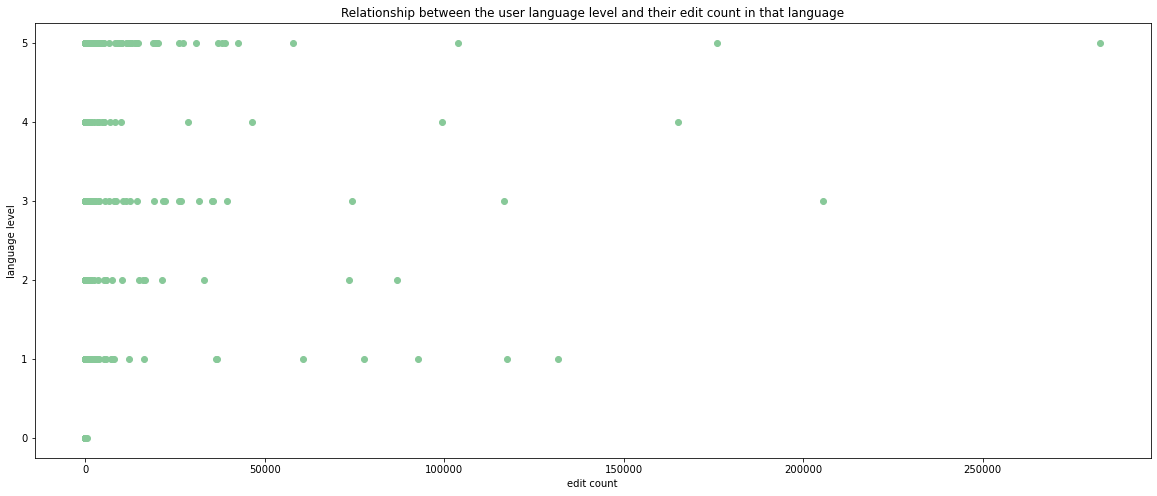

In [112]:
plt.scatter(df_users['edit_count'], df_users['level'], color = '#88c999')
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)

plt.rcParams["figure.figsize"] = (15,8)
plt.title("Relationship between the user language level and their edit count in that language")
plt.xlabel("edit count")
plt.ylabel("language level")
plt.show()

__Observations:__ []

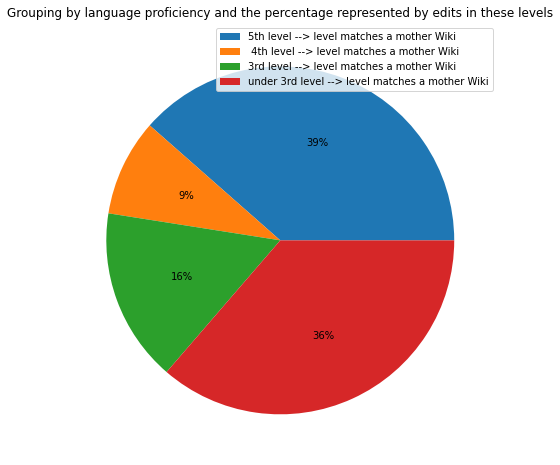

In [113]:
## Display pie

native_high_count_group = df_users.loc[(df_users['level'] == 5) & (df_users['edit count percentage'] > 65.0)]
proficient_high_count_group =  df_users.loc[(df_users['level'] == 4) & (df_users['edit count percentage'] > 65.0)]
sufficient_high_count_group =  df_users.loc[(df_users['level'] == 3) & (df_users['edit count percentage'] > 65.0)]
low_high_count_group =  df_users.loc[(df_users['level'] < 3) & (df_users['edit count percentage'] > 65.0)]

# get counts
counts_list = [native_high_count_group, proficient_high_count_group, sufficient_high_count_group, low_high_count_group]
counts_list_language_edit_number = [len(c) for c in counts_list]

# set labels
summary_labels = ["5th level --> level matches a mother Wiki", 
                  " 4th level --> level matches a mother Wiki", 
                  "3rd level --> level matches a mother Wiki", 
                  "under 3rd level --> level matches a mother Wiki"]

plt.rcParams["figure.figsize"] = (20,8)
plt.title("Grouping by language proficiency and the percentage represented by edits in these levels")
plt.pie(counts_list_language_edit_number, autopct='%.0f%%')
plt.legend( summary_labels, loc='best')
plt.show() 


__Observations:__ []

In [114]:
from enum import Enum

# we ar defining categories and benchmarks to group users
class EditCategory(Enum):
    BEGINNER = 30
    INTERMEDIATE = 100     
    EXPERT = 200
    

In [115]:
## Create a new category based on absolute numbers of the edit_count column
df_users['category'] = df_users.apply(lambda row: "beginner" if (row.edit_count < EditCategory.BEGINNER.value)
                                      else "intermediate" if (row.edit_count < EditCategory.INTERMEDIATE.value) 
                                      else "expert", axis = 1)

# out
df_users

,username,language,level,edit_count,edit count percentage,category
0,Olivier LPB,fr,5,0,NaN,beginner
1,Olivier LPB,en,2,0,NaN,beginner
2,Gamesmasterg9,en,5,0,0.00,beginner
3,Gamesmasterg9,hi,4,1,25.00,beginner
4,Gamesmasterg9,bn,3,0,0.00,beginner
...,...,...,...,...,...,...
1498,Porantim,es,1,2,0.01,beginner
1499,Porantim,gl,1,15,0.04,beginner
1500,Porantim,fr,0,0,0.00,beginner
1501,Kline,en,5,12942,100.00,expert


Text(0, 0.5, 'edit count')

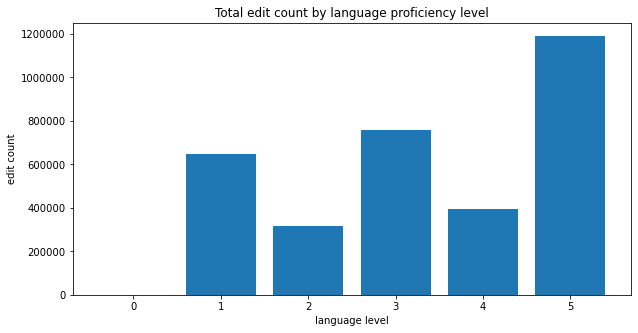

In [116]:
x = df_users.groupby(['level'], as_index=False)['edit_count'].sum()

fig = plt.figure(figsize = (10, 5))
plt.bar(x["level"], x["edit_count"])
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)

plt.rcParams["figure.figsize"] = (20,8)
plt.title("Total edit count by language proficiency level")
plt.xlabel("language level")
plt.ylabel("edit count")

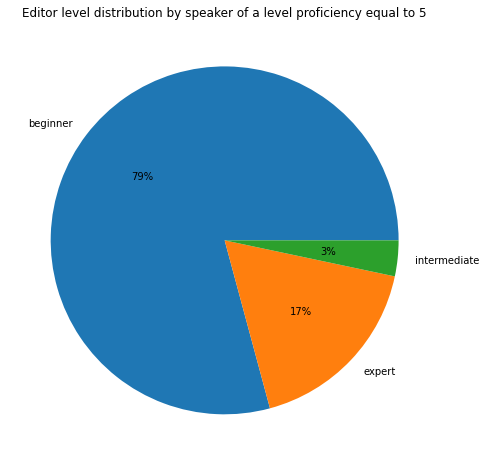

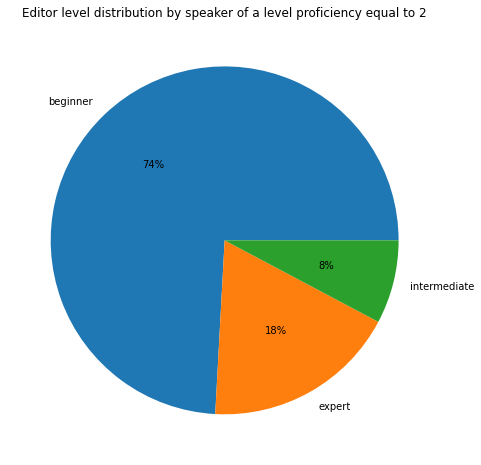

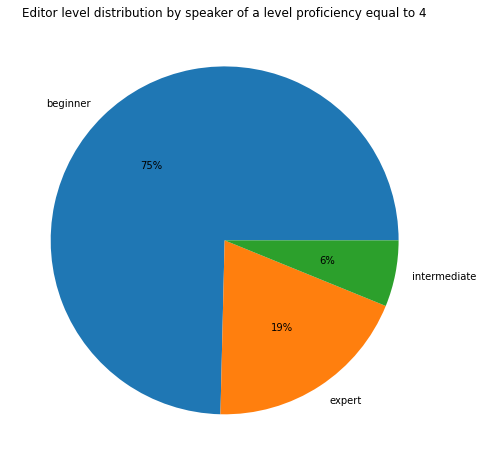

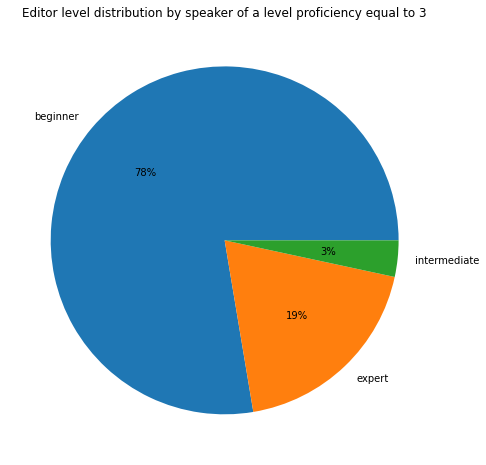

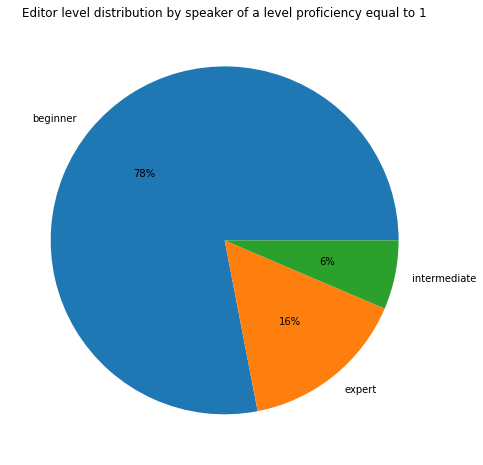

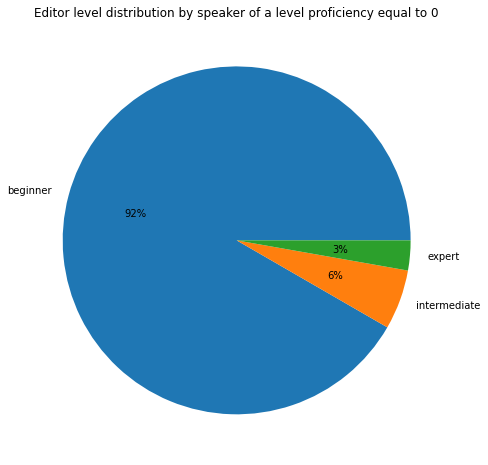

In [117]:
## Show distribution by specific language level
levels = a = df_users['level'].unique()

for level in levels:
    df = df_users.loc[(df_users['level'] == level)]
    data = df['category']
    values = data.value_counts().values.tolist()
    labels = data.value_counts().index.tolist()
    
    plt.rcParams["figure.figsize"] = (20,8)
    plt.title(f'Editor level distribution by speaker of a level proficiency equal to {level}')
    plt.pie(values, labels=labels, autopct='%.0f%%')
    plt.show()